<a href="https://colab.research.google.com/github/jbsher/capstone/blob/main/preprocess_eda_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brody Sherwood

## Capstone: Hagrid Hand Gesture Recognition

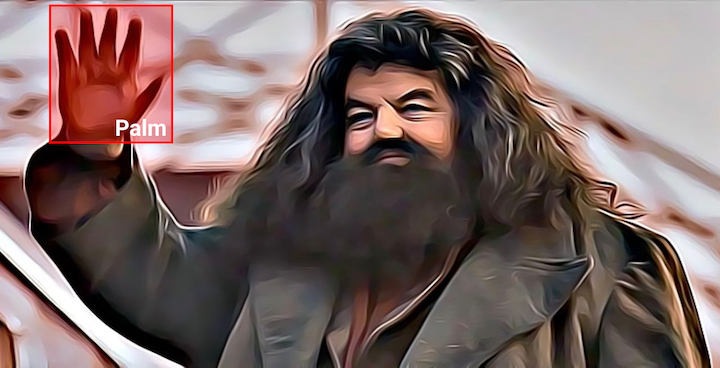

In [1]:
!pip install torchmetrics
!pip install tensorboardX


Imports

In [13]:
import os
import math
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pickle
import plotly.figure_factory as ff
import scipy.stats as stats
import plotly.graph_objects as go
import matplotlib.patches as patches
import tensorflow as tf
from PIL import Image
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorboardX import SummaryWriter

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from collections import defaultdict
import urllib

from torchvision import transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import average_precision_score
from typing import Tuple
from PIL import ImageOps
from ipywidgets import interact
from IPython.display import Image as DImage


In [4]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Read in**

Note: This dataset is a subset of 1000 images per category that was taken from a much larger dataset.

In [7]:
class_names = [
   'call',
   'dislike',
   'fist',
   'four',
   'like',
   'mute',
   'ok',
   'one',
   'palm',
   'peace_inverted',
   'peace',
   'rock',
   'stop_inverted',
   'stop',
   'three',
   'three2',
   'two_up',
   'two_up_inverted',
   ]

FORMATS = (".jpg")

transform = T.ToTensor()

# Paths to data
path_to_train = "/content/drive/MyDrive/capstone/data/train_val"
path_to_test = "/content/drive/MyDrive/capstone/data/test_"
path_to_annotations = '/content/drive/MyDrive/capstone/data/ann_train/'
path_to_subset_annotations = '/content/drive/MyDrive/capstone/data/ann_train_subset/'
path_to_test_annotations = '/content/drive/MyDrive/capstone/data/ann_test/'


**Preprocessor and import functions.**

In [8]:
# Preprocesser function
def preprocess_image_tf(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [320, 320])
    img = (tf.cast(img, tf.float32) / 255.0 - 0.5) * 2
    return img

Normalizing pixel values to between -1 and 1 since it uses less computing power when values are centered on 0.

In [9]:
def load_json_for_category(category, path_to_data):
    json_filepath = os.path.join(path_to_data, f"{category}.json")

    with open(json_filepath, 'r') as json_file:
        data = json.load(json_file)

    return data

def filter_json_by_images(json_data, available_images):
    return {uuid: meta for uuid, meta in json_data.items() if f"{uuid}.jpg" in available_images}


In [10]:
image_path_dict = {}
for category in class_names:
    category_folder = os.path.join(path_to_train, category)
    for filename in os.listdir(category_folder):
        if filename.endswith('.jpg'):
            uuid = filename.split('.')[0]
            image_path_dict[uuid] = os.path.join(category_folder, filename)

json_by_category = {category: load_json_for_category(category, path_to_annotations) for category in class_names}

combined_json_data = []
for category in class_names:
    for img_uuid, metadata in json_by_category[category].items():
        image_filepath = image_path_dict.get(img_uuid, None)
        if image_filepath:
            combined_json_data.append(((category, img_uuid), metadata))

filepaths = [image_path_dict[item[0][1]] for item in combined_json_data if item[0][1] in image_path_dict]
metadata_list = [{'bboxes': item[1]['bboxes'], 'labels': item[1]['labels']} for item in combined_json_data if item[0][1] in image_path_dict]


In [11]:
subset_annotations = {category: {} for category in class_names}
for (category, uuid), metadata in combined_json_data:
    subset_annotations[category][uuid] = metadata

if not os.path.exists(path_to_subset_annotations):
    os.makedirs(path_to_subset_annotations)

for category, annotations in subset_annotations.items():
    with open(os.path.join(path_to_subset_annotations, f"{category}.json"), "w") as file:
        json.dump(annotations, file)


In [9]:
#data = {}
#for category in class_names:
#    files_in_category = os.listdir(os.path.join(path_to_train, category))
#     category_uuids = [os.path.splitext(filename)[0] for filename in files_in_category if filename.endswith('.jpg')]
#     data[category] = category_uuids

# uuids_df = pd.DataFrame.from_dict(data, orient='index').transpose()


In [ ]:
# master_data = []

# for (category, uuid), metadata in combined_json_data:
#     data_point = {
#         'category': category,
#         'uuid': uuid,
#         'image_path': image_path_dict[uuid],
#         'label': metadata['labels'][0],  # Assuming one label per image
#         'bbox': metadata['bboxes']
#     }
#     master_data.append(data_point)

# master_df = pd.DataFrame(master_data)


In [33]:
class_names = [
   'call',
   'dislike',
   'fist',
   'four',
   'like',
   'mute',
   'ok',
   'one',
   'palm',
   'peace_inverted',
   'peace',
   'rock',
   'stop_inverted',
   'stop',
   'three',
   'three2',
   'two_up',
   'two_up_inverted',
   'no_gesture']

class GestureDataset(torch.utils.data.Dataset):

    @staticmethod
    def __get_files_from_dir(pth: str, extns: Tuple):
        if not os.path.exists(pth):
            print(f"Dataset directory doesn't exist {pth}")
            return []
        files = [f for f in os.listdir(pth) if f.endswith(extns)]
        return files

    def __read_annotations(self, path):
      annotations_all = None
      exists_images = []

      # Create a dictionary to keep track of images with 2 bounding boxes
      images_with_two_bboxes = {}

      for target in class_names:
          path_to_csv = os.path.join(path, f"{target}.json")
          if os.path.exists(path_to_csv):
              json_annotation = json.load(open(
                  os.path.join(path, f"{target}.json")
              ))

              json_annotation = [dict(annotation, **{"name": f"{name}.jpg"}) for name, annotation in
                                zip(json_annotation, json_annotation.values())]

              annotation = pd.DataFrame(json_annotation)

              annotation["target"] = target
              annotations_all = pd.concat([annotations_all, annotation], ignore_index=True)
              exists_images.extend(
                  self.__get_files_from_dir(os.path.join(self.path_images, target), FORMATS))

              # Check if the image has 2 bounding boxes
              if target == 'no_gesture':
                  images_with_two_bboxes.update(annotation["name"].value_counts().to_dict())

      annotations_all["exists"] = annotations_all["name"].isin(exists_images)

      annotations_all = annotations_all[annotations_all["exists"]]

      users = annotations_all["user_id"].unique()
      users = sorted(users)
      random.Random(42).shuffle(users)
      train_users = users[:int(len(users) * 0.8)]
      val_users = users[int(len(users) * 0.8):]

      annotations_all = annotations_all.copy()

      if self.is_train:
          annotations_all = annotations_all[annotations_all["user_id"].isin(train_users)]
      else:
          annotations_all = annotations_all[annotations_all["user_id"].isin(val_users)]

      # Update the labels for images with 2 bounding boxes
      annotations_all.loc[annotations_all['name'].isin(images_with_two_bboxes.keys()), 'target'] = 'no_gesture'

      return annotations_all


    def __init__(self, path_annotation, path_images, is_train, transform=None, target_size=(320, 320)):
        print("Initializing GestureDataset")
        self.is_train = is_train
        self.transform = transform
        self.path_annotation = path_annotation
        self.path_images = path_images
        self.transform = transform
        self.target_size = target_size  # Set your desired target size here
        self.labels = {label: num for (label, num) in
                      zip(class_names, range(len(class_names)))}
        self.annotations = self.__read_annotations(self.path_annotation)
        print(f"Dataset Size: {len(self)}")

    def __len__(self):
        return self.annotations.shape[0]

    def get_sample(self, index: int):
        row = self.annotations.iloc[[index]].to_dict('records')[0]
        image_pth = os.path.join(self.path_images, row["target"], row["name"])
        image = Image.open(image_pth).convert("RGB")

        # Resize the image to the target size
        image = image.resize(self.target_size)

        labels = torch.LongTensor([self.labels[label] for label in row["labels"]])

        target = {}
        width, height = image.size

        bboxes = []

        for bbox in row["bboxes"]:
            x1, y1, w, h = bbox
            bbox_abs = [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]
            bboxes.append(bbox_abs)

        target["labels"] = labels
        target["boxes"] = torch.as_tensor(bboxes, dtype=torch.float32)
        target["orig_size"] = torch.as_tensor([int(height), int(width)])

        return image, target

        return image, target

    def __getitem__(self, index: int):
        image, target = self.get_sample(index)
        if self.transform:
            image = self.transform(image)
        return image, target


In [34]:
random_seed = 42
num_classes = len(class_names)
batch_size = 16
num_epoch = 15

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_data = GestureDataset(path_images=path_to_train,
                            path_annotation=path_to_subset_annotations,
                            is_train=True, transform=transform)

test_data = GestureDataset(path_images=path_to_test,
                            path_annotation=path_to_test_annotations,
                            is_train=False, transform=transform)



Initializing GestureDataset
Dataset Size: 13932
Initializing GestureDataset
Dataset Size: 24


In [30]:
def collate_fn(batch):
    batch_targets = list()
    images = list()

    for b in batch:
        images.append(b[0])
        batch_targets.append({"boxes": b[1]["boxes"],
                              "labels": b[1]["labels"]})
    return images, batch_targets

In [31]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,collate_fn=collate_fn, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,collate_fn=collate_fn, shuffle=True, num_workers=4)

In [37]:
class GestureDataset(Dataset):
    def __init__(self, path_annotation, path_images, is_train, transform=None):
        self.is_train = is_train
        self.transform = transform
        self.path_annotation = path_annotation
        self.path_images = path_images
        self.labels = {label: num for (label, num) in zip(class_names, range(len(class_names)))}
        self.annotations = self.__read_annotations(self.path_annotation)

    @staticmethod
    def __get_files_from_dir(pth: str, extns: Tuple):
        if not os.path.exists(pth):
            print(f"Dataset directory doesn't exist {pth}")
            return []
        files = [f for f in os.listdir(pth) if f.endswith(extns)]
        return files

    def __read_annotations(self, path):
        annotations_all = None
        exists_images = []

        for target in class_names:
            path_to_csv = os.path.join(path, f"{target}.json")

            if os.path.exists(path_to_csv):
                json_annotation = json.load(open(os.path.join(path, f"{target}.json")))

                json_annotation = [dict(annotation, **{"name": f"{name}.jpg"}) for name, annotation in
                                   zip(json_annotation, json_annotation.values())]

                annotation = pd.DataFrame(json_annotation)
                annotation["target"] = target
                annotations_all = pd.concat([annotations_all, annotation], ignore_index=True)
                exists_images.extend(self.__get_files_from_dir(os.path.join(self.path_images, target), FORMATS))
            else:
                if target != 'no_gesture':
                    print(f"Database for {target} not found")

        annotations_all["exists"] = annotations_all["name"].isin(exists_images)
        annotations_all = annotations_all[annotations_all["exists"]]

        users = annotations_all["user_id"].unique()
        users = sorted(users)
        random.Random(42).shuffle(users)
        train_users = users[:int(len(users) * 0.8)]
        val_users = users[int(len(users) * 0.8):]

        annotations_all = annotations_all.copy()

        if self.is_train:
            annotations_all = annotations_all[annotations_all["user_id"].isin(train_users)]
        else:
            annotations_all = annotations_all[annotations_all["user_id"].isin(val_users)]

        self.annotations_all = annotations_all

    def __len__(self):
        return self.annotations_all.shape[0]

    def get_sample(self, index: int):
        row = self.annotations_all.iloc[[index]].to_dict('records')[0]
        image_pth = os.path.join(self.path_images, row["target"], row["name"])
        image = Image.open(image_pth).convert("RGB")

        labels = torch.LongTensor([self.labels[label] for label in row["labels"]])

        target = {}
        width, height = image.size

        bboxes = []

        for bbox in row["bboxes"]:
            x1, y1, w, h = bbox
            bbox_abs = [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]
            bboxes.append(bbox_abs)

        target["labels"] = labels
        target["boxes"] = torch.as_tensor(bboxes, dtype=torch.float32)
        target["orig_size"] = torch.as_tensor([int(height), int(width)])

        return image, target

    def __getitem__(self, index: int):
        image, target = self.get_sample(index)
        if self.transform:
            image = self.transform(image)
        return image, target

KAGGLE MODEL

In [40]:
lr = 0.005
momentum = 0.9
weight_decay = 5e-4

model = models.detection.ssdlite320_mobilenet_v3_large(num_classes=len(class_names) + 1, pretrained_backbone=True)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
warmup_factor = 1.0 / 1000
warmup_iters = min(1000, len(train_data) - 1)

lr_scheduler_warmup = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=warmup_factor, total_iters=warmup_iters
)

In [41]:
def eval(model, test_dataloader, epoch):
    model.eval()
    with torch.no_grad():
        mapmetric = MeanAveragePrecision()

        for images, targets in test_dataloader:
            images = list(image.to(device) for image in images)
            output = model(images)

            for pred in output:
                for key, value in pred.items():
                    pred[key] = value.cpu()

            mapmetric.update(output, targets)

    metrics = mapmetric.compute()
    return metrics

In [ ]:
!mkdir checkpoints
for epoch in range(num_epoch):
    model.train()
    total = 0
    sum_loss = 0
    for images, targets in tqdm(train_dataloader):
        batch = len(images)
        images = list(image.to(device) for image in images)
        for target in targets:
            for key, value in target.items():
                target[key] = value.to(device)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        lr_scheduler_warmup.step()

        total = total + batch
        sum_loss = sum_loss + loss
    metrics = eval(model, test_dataloader, epoch)
    print(f"epoch : {epoch}  |||  loss : {sum_loss / total} ||| MAP : {metrics['map']}")
torch.save(model.state_dict(),f"checkpoints/{epoch}.pth")

mkdir: cannot create directory ‘checkpoints’: File exists


100%|██████████| 871/871 [04:11<00:00,  3.46it/s]
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


epoch : 0  |||  loss : 0.1892472116761669 ||| MAP : 0.3895031213760376


100%|██████████| 871/871 [04:22<00:00,  3.32it/s]


epoch : 1  |||  loss : 0.14059125582205986 ||| MAP : 0.4306916892528534


100%|██████████| 871/871 [04:25<00:00,  3.28it/s]


epoch : 2  |||  loss : 0.11893373530143093 ||| MAP : 0.49784138798713684


100%|██████████| 871/871 [04:24<00:00,  3.29it/s]


epoch : 3  |||  loss : 0.10478179649207361 ||| MAP : 0.49176687002182007


100%|██████████| 871/871 [04:20<00:00,  3.35it/s]


epoch : 4  |||  loss : 0.0964964484555811 ||| MAP : 0.4734177887439728


100%|██████████| 871/871 [04:23<00:00,  3.30it/s]


epoch : 5  |||  loss : 0.08824491089286388 ||| MAP : 0.5020260810852051


100%|██████████| 871/871 [04:15<00:00,  3.41it/s]


epoch : 6  |||  loss : 0.0830269975118722 ||| MAP : 0.5223566293716431


100%|██████████| 871/871 [04:11<00:00,  3.46it/s]


epoch : 7  |||  loss : 0.07681745969287425 ||| MAP : 0.526303768157959


100%|██████████| 871/871 [04:07<00:00,  3.52it/s]


epoch : 8  |||  loss : 0.07264051422318472 ||| MAP : 0.527711033821106


100%|██████████| 871/871 [04:04<00:00,  3.57it/s]


epoch : 9  |||  loss : 0.07005345150550275 ||| MAP : 0.5347555875778198


100%|██████████| 871/871 [04:04<00:00,  3.57it/s]


epoch : 10  |||  loss : 0.06732545758830451 ||| MAP : 0.5148270726203918


 81%|████████  | 705/871 [03:17<00:56,  2.95it/s]

In [ ]:
torch.save(model.state_dict(), f"checkpoints/{epoch}.pth")

In [ ]:
# Test model
images = []
for gesture in class_names[:-1]:
    image_path = os.path.join(path_to_test, gesture, "*.jpg")
    images.append(Image.open(image_path))

images_tensors = images.copy()
images_tensors_input = list(transform(image).to(device) for image in images_tensors)
with torch.no_grad():
    model.eval()
    out = model(images_tensors_input)

In [ ]:
bboxes = []
scores = []
labels = []
for pred in out:
    ids = pred['scores'] >= 0.2
    bboxes.append(pred['boxes'][ids][:2].cpu().numpy().astype(np.int))
    scores.append(pred['scores'][ids][:2].cpu().numpy())
    labels.append(pred['labels'][ids][:2].cpu().numpy())

In [ ]:
short_class_names = []

for name in class_names:
    if name == 'stop_inverted':
        short_class_names.append('stop inv.')
    elif name == 'peace_inverted':
        short_class_names.append('peace inv.')
    elif name == 'two_up':
        short_class_names.append('two up')
    elif name == 'two_up_inverted':
        short_class_names.append('two up inv.')
    elif name == 'no_gesture':
        short_class_names.append('no gesture')
    else:
        short_class_names.append(name)

In [ ]:
final_images = []
for bbox, score, label, image in zip(bboxes, scores, labels, images):
    image = np.array(image)
    for i, box in enumerate(bbox):
        _,width,_  = image.shape
        image = cv2.rectangle(image, box[:2], box[2:], thickness=3, color=[255, 0, 255])
        cv2.putText(image, f'{short_class_names[label[i]]}: {score[i]:0.2f}', (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX,
                        width / 780, (0, 0, 255), 2)
    final_images.append(Image.fromarray(image))

In [ ]:
!mkdir out_images
out_images = []
for i, image in enumerate(final_images):
    out_name = f"out_images/{i}.png"
    out_images.append(out_name)
    image.save(out_name)

In [ ]:
out_dir = "out_images/"
@interact
def show_images(file=os.listdir(out_dir)):
    display(DImage(out_dir+file, width=600, height=300))

CUSTOM MODEL

In [ ]:
# Define the Sequential model
model = nn.Sequential(
    # First convolutional layer
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Second convolutional layer
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Third convolutional layer
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Flatten the output for fully connected layers
    nn.Flatten(),

    # Fully connected layers
    nn.Linear(in_features=64*40*40, out_features=128),  # Adjust the input size as needed
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=len(class_names) + 1),  # Adjust the output size
)

# Move the model to the specified device (e.g., GPU)
model.to(device)

In [ ]:
# Define a function for the training loop
def train_model(model, train_dataloader, optimizer, lr_scheduler_warmup, device, num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    total_samples = 0

    for epoch in range(num_epochs):
        total = 0
        sum_loss = 0

        for images, targets in tqdm(train_dataloader):
            batch = len(images)
            images = list(image.to(device) for image in images)
            for target in targets:
                for key, value in target.items():
                    target[key] = value.to(device)
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss = losses.item()

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            lr_scheduler_warmup.step()

            total = total + batch
            sum_loss = sum_loss + loss

        # Calculate and print training loss
        avg_loss = sum_loss / total
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {avg_loss:.4f}")

# Define a function for model evaluation
def evaluate_model(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate and print test accuracy
    test_accuracy = total_correct / total_samples
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Create the "checkpoints" directory if it doesn't exist
os.makedirs("checkpoints", exist_ok=True)

# Call the training and evaluation functions
train_model(model, train_dataloader, optimizer, lr_scheduler_warmup, device, num_epoch)
evaluate_model(model, test_dataloader, device)

# Save the trained model
torch.save(model.state_dict(), "checkpoints/final_model.pth")


In [ ]:
uuids_df.to_csv('/content/drive/MyDrive/capstone/data/uuids_df.csv', index=False)
master_df.to_csv('/content/drive/MyDrive/capstone/data/master_df.csv', index=False)


In [ ]:
# Save combined_json_data
with open('/content/drive/MyDrive/capstone/data/combined_json_data.json', 'w') as f:
    json.dump(combined_json_data, f)

In [ ]:
# Image paths
with open('/content/drive/MyDrive/capstone/data/image_path_dict.json', 'w') as f:
    json.dump(image_path_dict, f)

*Test*

---
LOAD DATA

---

*Train*

In [15]:
uuids_df = pd.read_csv('/content/drive/MyDrive/capstone/data/uuids_df.csv')
master_df = pd.read_csv('/content/drive/MyDrive/capstone/data/master_df.csv')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/capstone/data/train.csv')


In [ ]:
with open('/content/drive/MyDrive/capstone/data/avg_rgb_by_category.pkl', 'rb') as file:
    avg_rgb_by_category = pickle.load(file)

*Test*

---
Statistical Features

NOTE: The colors chosen for plotting were tested on simulators of all kinds of colorblindess to ensure readability.

https://www.color-blindness.com/coblis-color-blindness-simulator/

In [ ]:
# Load image from file path
def load_image_from_filepath(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_average_rgb(image):
    return np.mean(image, axis=(0, 1))

avg_rgb_by_category = {}

# Initialize category data
for category in class_names:
    avg_rgb_by_category[category] = []

for (category, img_uuid), meta in combined_json_data:
    # Use image_path_dict to get the correct path
    image_path = image_path_dict.get(img_uuid)
    if image_path:  # Ensure the path exists
        image = load_image_from_filepath(image_path)
        avg_rgb = get_average_rgb(image)
        avg_rgb_by_category[category].append(avg_rgb)

for category in avg_rgb_by_category:
    avg_rgb_by_category[category] = np.mean(avg_rgb_by_category[category], axis=0)


In [ ]:
# Saving 'avg_rgb_by_category' to a pickle file
with open('/content/drive/MyDrive/capstone/data/avg_rgb_by_category.pkl', 'wb') as file:
    pickle.dump(avg_rgb_by_category, file)


In [ ]:
def plot_rgb_for_subset(categories_subset, subset_number):
    avg_rgb_subset = [avg_rgb_by_category[cat] for cat in categories_subset]

    # Create table data
    table_data = [['Category', 'Avg Red', 'Avg Green', 'Avg Blue']]
    for cat, rgb in zip(categories_subset, avg_rgb_subset):
        table_data.append([cat, round(rgb[0], 2), round(rgb[1], 2), round(rgb[2], 2)])

    # Create the table figure
    fig = ff.create_table(table_data, height_constant=60)

    # Bar chart data
    avg_red = [round(rgb[0], 2) for rgb in avg_rgb_subset]
    avg_green = [round(rgb[1], 2) for rgb in avg_rgb_subset]
    avg_blue = [round(rgb[2], 2) for rgb in avg_rgb_subset]

    # Create bar chart traces
    trace1 = go.Bar(x=categories_subset, y=avg_red, xaxis='x2', yaxis='y2', marker=dict(color='#AB3640'), name='Avg Red')
    trace2 = go.Bar(x=categories_subset, y=avg_green, xaxis='x2', yaxis='y2', marker=dict(color='#C7D01D'), name='Avg Green')
    trace3 = go.Bar(x=categories_subset, y=avg_blue, xaxis='x2', yaxis='y2', marker=dict(color='#7E7ED8'), name='Avg Blue')

    # Add bar chart traces to the figure
    fig.add_traces([trace1, trace2, trace3])

    # Initialize xaxis2 and yaxis2
    fig['layout']['xaxis2'] = {}
    fig['layout']['yaxis2'] = {}

    # Edit layout for subplots
    fig.layout.yaxis.update({'domain': [0, .45]})
    fig.layout.yaxis2.update({'domain': [.6, 1]})
    fig.layout.yaxis2.update({'anchor': 'x2'})
    fig.layout.xaxis2.update({'anchor': 'y2'})
    fig.layout.yaxis2.update({'title': 'RGB Values'})

    # Update the margins to add a title and see graph x-labels
    fig.layout.margin.update({'t': 75, 'l': 50})
    fig.layout.update({'title': f'Average RGB values for Categories ({subset_number})'})

    # Adjust the height
    fig.layout.update({'height': 800})

    # Display the plot
    fig.show()

# Now, you can use the provided function to plot
all_categories = list(avg_rgb_by_category.keys())
for i in range(0, len(all_categories), 6):
    subset = all_categories[i:i+6]
    plot_rgb_for_subset(subset, f"{i+1}-{i+len(subset)}")


In [ ]:
# Retrieve the top categories based on average color values
def top_categories_for_color(color_index, n=3):
    sorted_categories = sorted(avg_rgb_by_category.items(),
                               key=lambda x: x[1][color_index],
                               reverse=True)
    return [cat[0] for cat in sorted_categories[:n]]

top_red = top_categories_for_color(0)
top_green = top_categories_for_color(1)
top_blue = top_categories_for_color(2)

unique_top_categories = list(set(top_red + top_green + top_blue))

plot_rgb_for_subset(unique_top_categories, "Top Categories by RGB")

***'two_up'*** has the highest average **Red**, with ***'call'*** having both the highest average **Green** and **Blue.**





Lets take a look at some sample images as well as their rgb color characteristics.

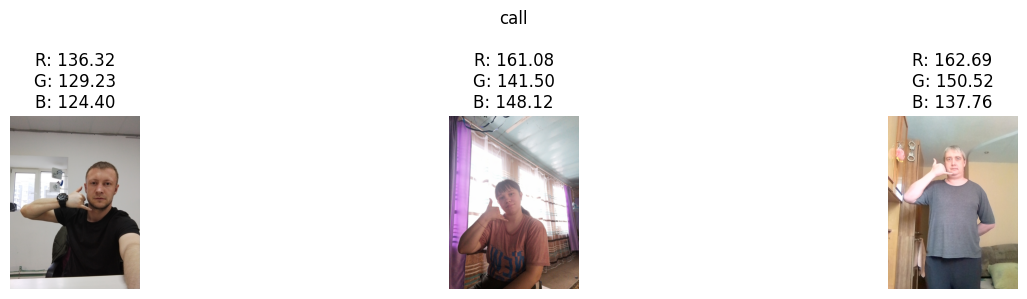

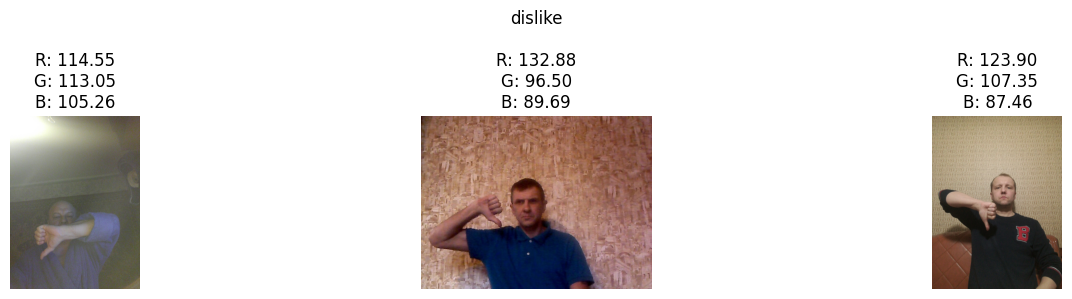

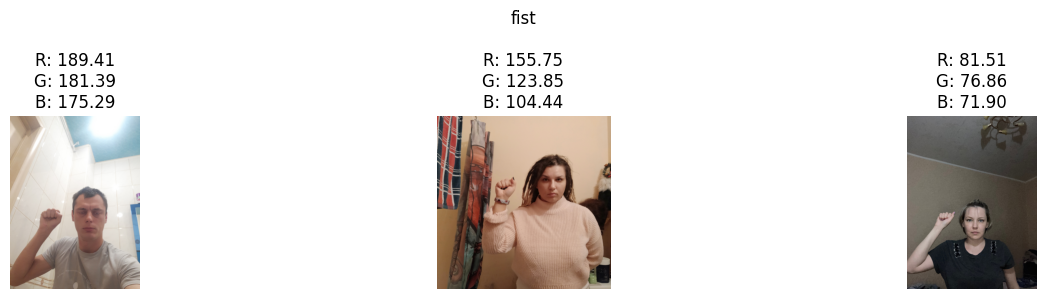

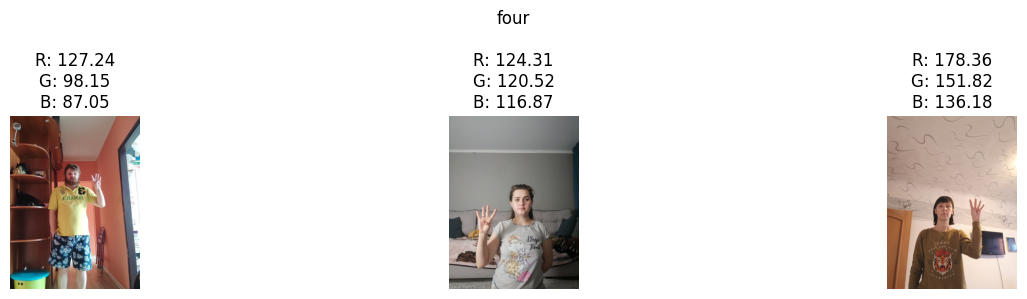

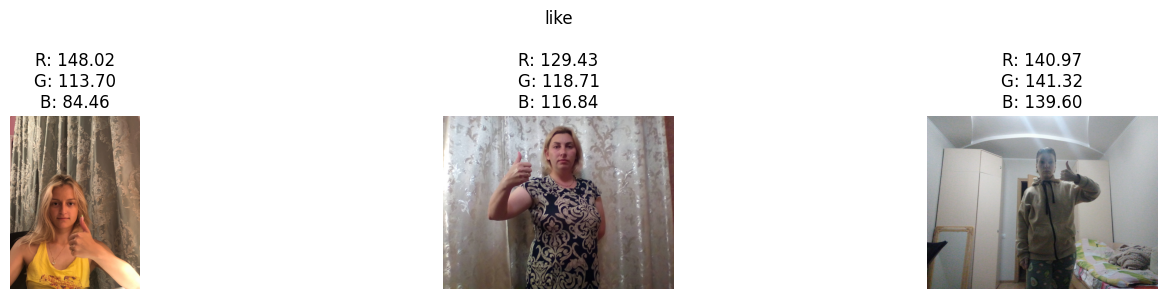

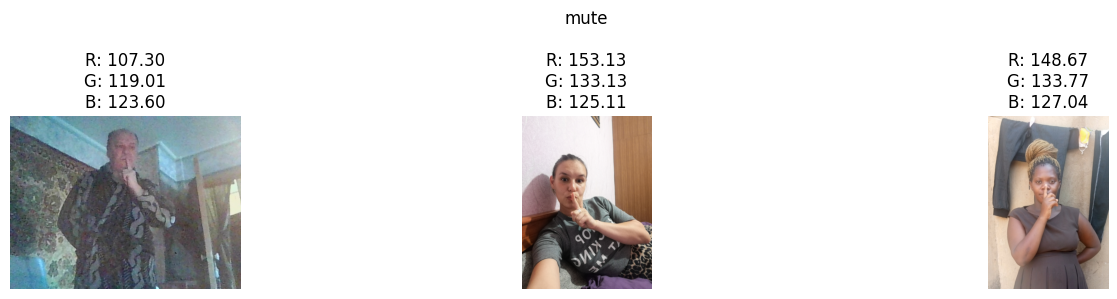

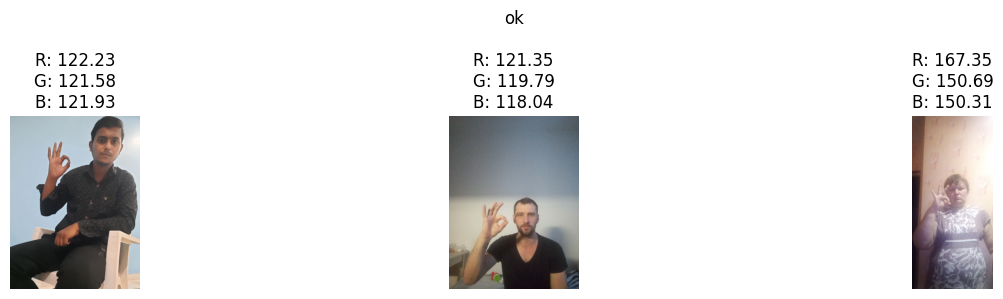

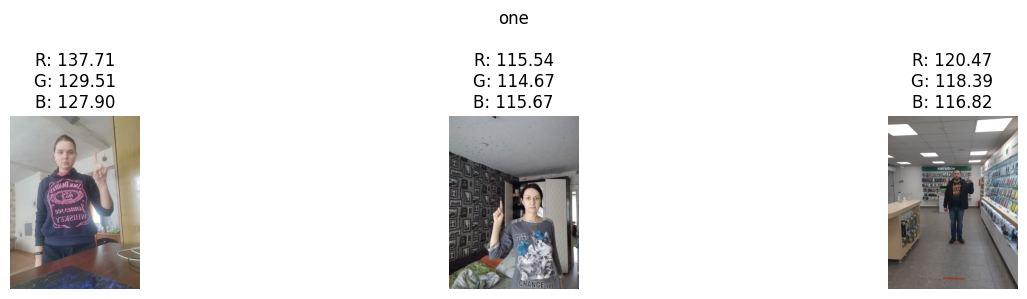

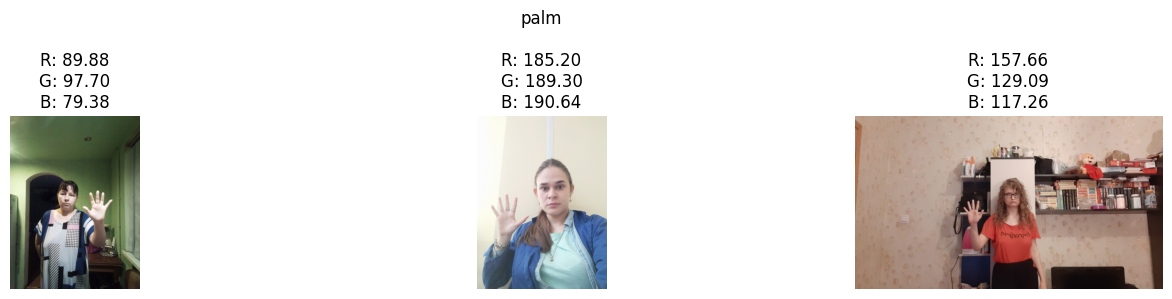

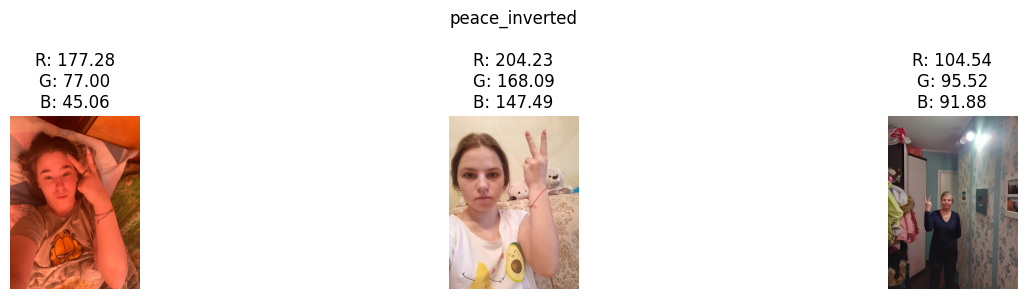

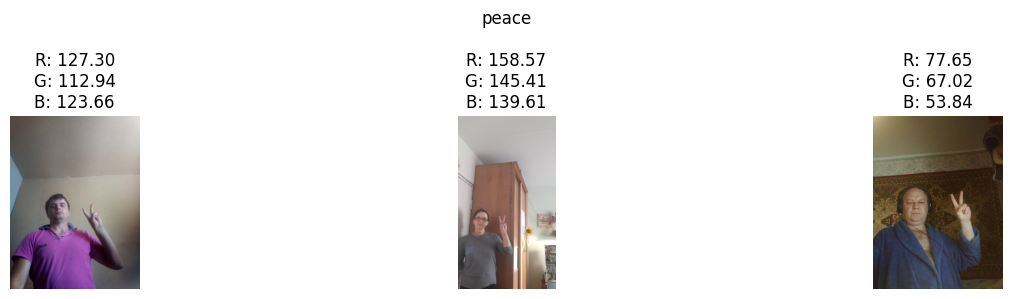

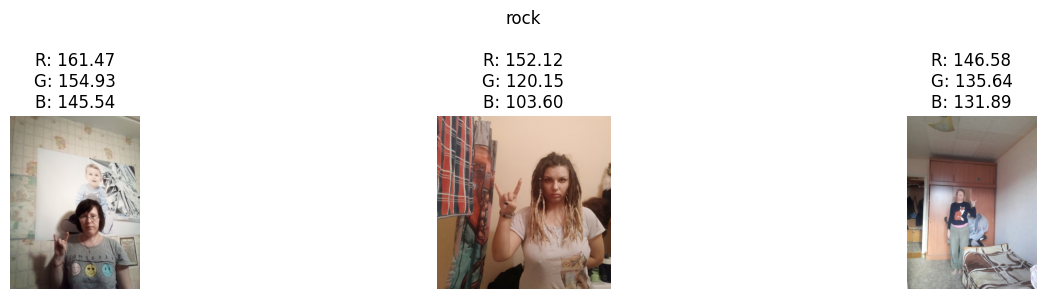

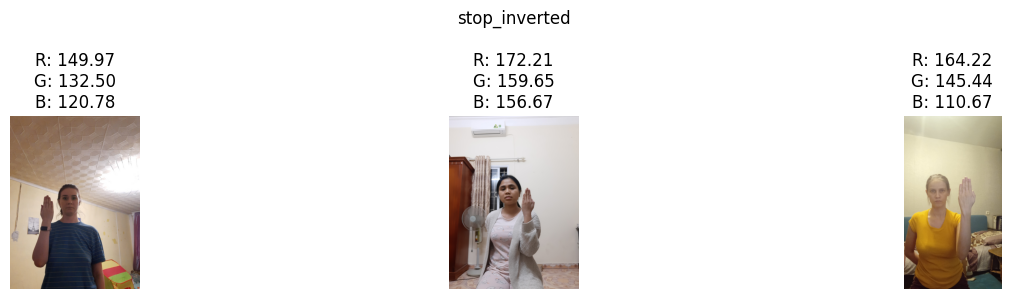

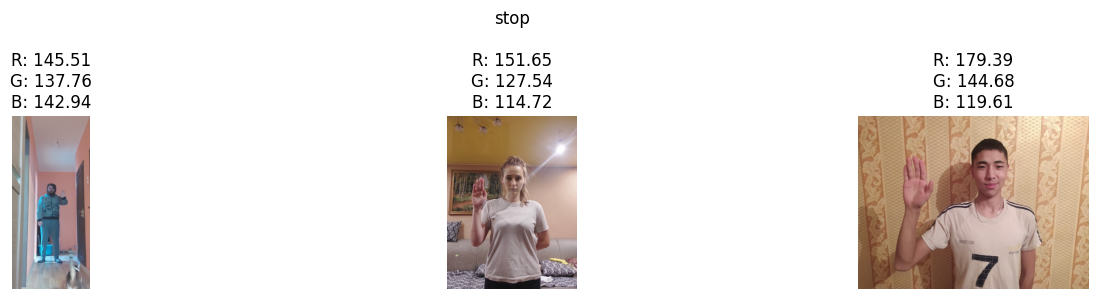

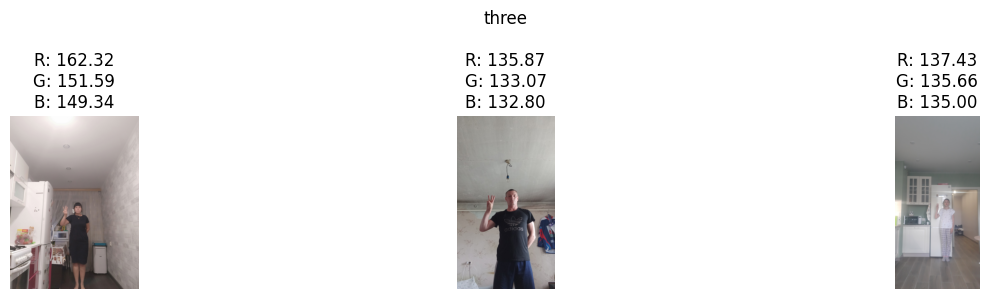

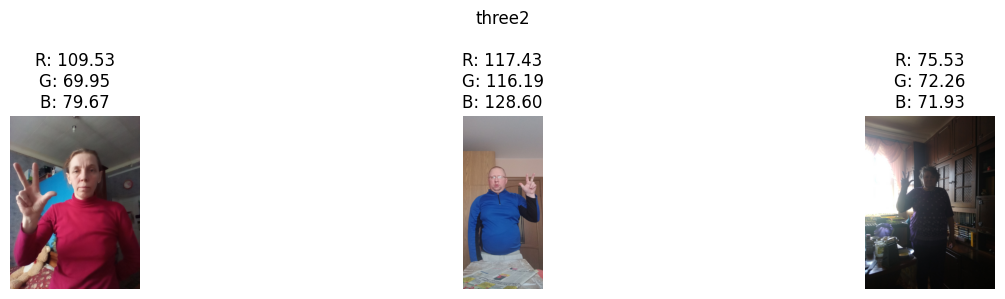

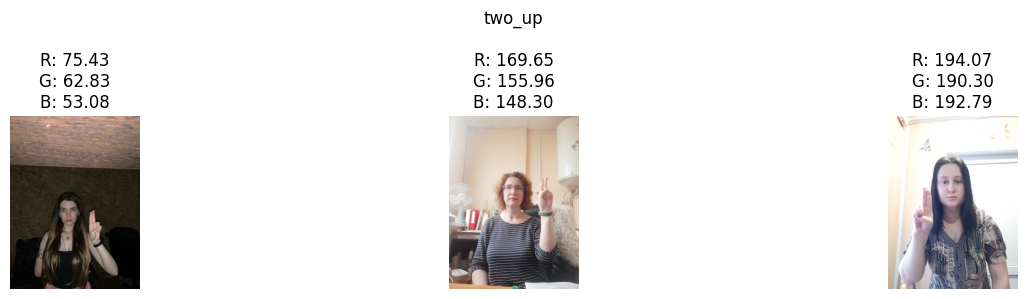

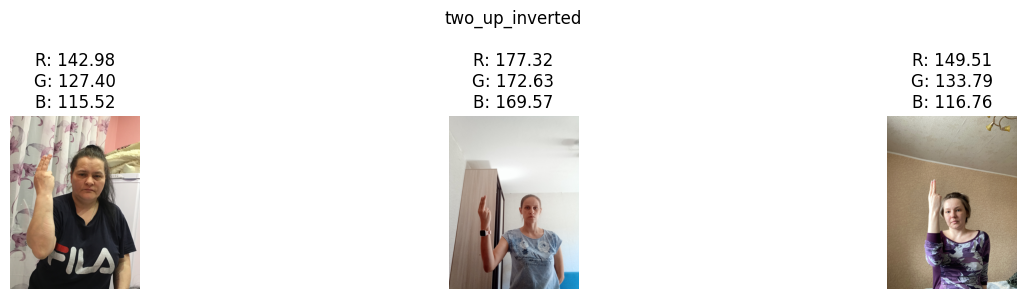

In [ ]:
# Display sample images with their average RGB values
def display_sample_images_with_rgb(data, num_samples=3):
    # Group data by category
    data_by_category = {}
    for (category, img_uuid), _ in data:
        if category not in data_by_category:
            data_by_category[category] = []
        data_by_category[category].append(img_uuid)

    for category, uuids in data_by_category.items():
        sample_uuids = np.random.choice(uuids, num_samples, replace=False)
        sample_filepaths = [os.path.join(path_to_train, category, f"{uuid}.jpg") for uuid in sample_uuids]

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        fig.suptitle(category)

        for ax, filepath in zip(axes, sample_filepaths):
            img = load_image_from_filepath(filepath)
            avg_rgb = get_average_rgb(img)

            ax.imshow(img)
            ax.set_title(f"R: {avg_rgb[0]:.2f}\nG: {avg_rgb[1]:.2f}\nB: {avg_rgb[2]:.2f}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()

display_sample_images_with_rgb(combined_json_data)

Many of these images were either very dark, pixelated, or the person in the picture is far away, making it difficult to make out the hand sign. For this reason, I *increased* the image resolution from **128** **x** **128** to **516** **x** **516** for more detail during modeling. Seen above are the latter images.

Visualizing landmarks and bounding boxes

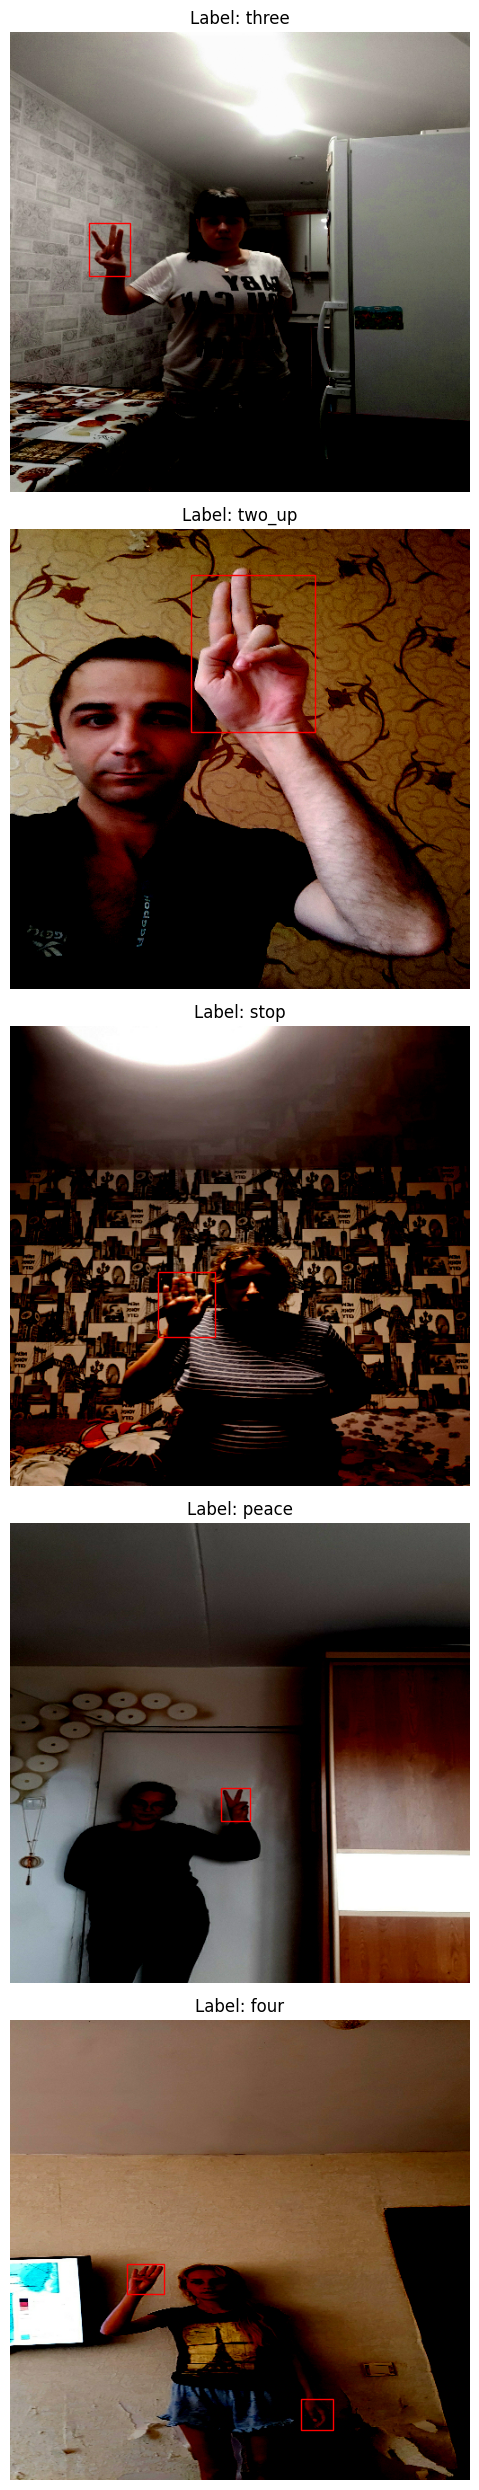

In [ ]:
def visualize_data_with_bboxes(dataset, num_samples=5):
    """
    Visualize the data with associated UUIDs and bounding boxes.

    Args:
    - dataset: The dataset object.
    - num_samples: Number of random samples to visualize.
    """
    fig, axs = plt.subplots(num_samples, figsize=(5, 25))

    # Extract a batch from the dataset
    for batch in dataset.take(1):  # Only taking one batch for visualization
        images, labels, bboxes_batch = batch

        # Randomly select data samples from the batch
        sample_indices = np.random.choice(len(images), num_samples, replace=False)

        for i, idx in enumerate(sample_indices):
            img = images[idx].numpy()
            bboxes = bboxes_batch[idx].numpy()

            # If the image tensor is a numpy array, we can directly plot it
            axs[i].imshow(img)
            title_text = f"Label: {labels[idx].numpy().decode('utf-8')}"
            axs[i].set_title(title_text)

            # Draw bounding boxes
            for bbox in bboxes:
                if np.any(bbox):  # Check if the bounding box is not [0,0,0,0] (padded value)
                    x, y, width, height = bbox[0] * img.shape[1], bbox[1] * img.shape[0], bbox[2] * img.shape[1], bbox[3] * img.shape[0]
                    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
                    axs[i].add_patch(rect)

            axs[i].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the data
visualize_data_with_bboxes(dataset)


Bounding Box Distribution

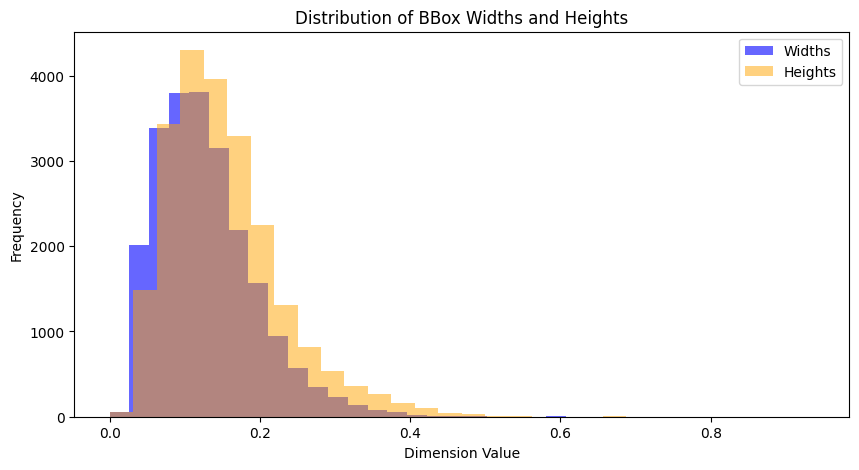

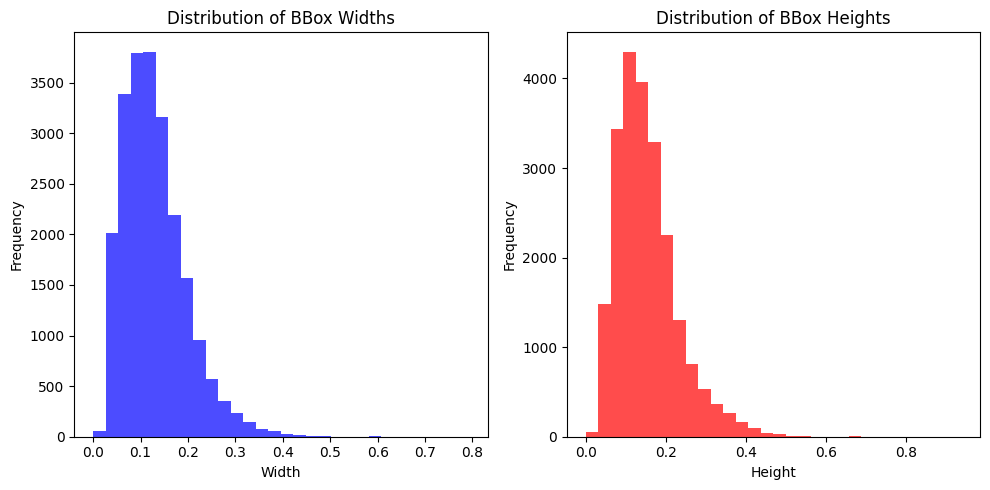

In [ ]:
plt.figure(figsize=(10, 5))

plt.hist(bbox_widths, bins=30, color='blue', alpha=0.6, label='Widths')
plt.hist(bbox_heights, bins=30, color='orange', alpha=0.5, label='Heights')

plt.title('Distribution of BBox Widths and Heights')
plt.xlabel('Dimension Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()

bbox_widths = []
bbox_heights = []

for entry in combined_json_data:
    bboxes = entry[1]['bboxes']
    for bbox in bboxes:
        x, y, w, h = bbox
        bbox_widths.append(w)
        bbox_heights.append(h)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(bbox_widths, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of BBox Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(bbox_heights, bins=30, color='red', alpha=0.7)
plt.title('Distribution of BBox Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Bounding Box Heatmap

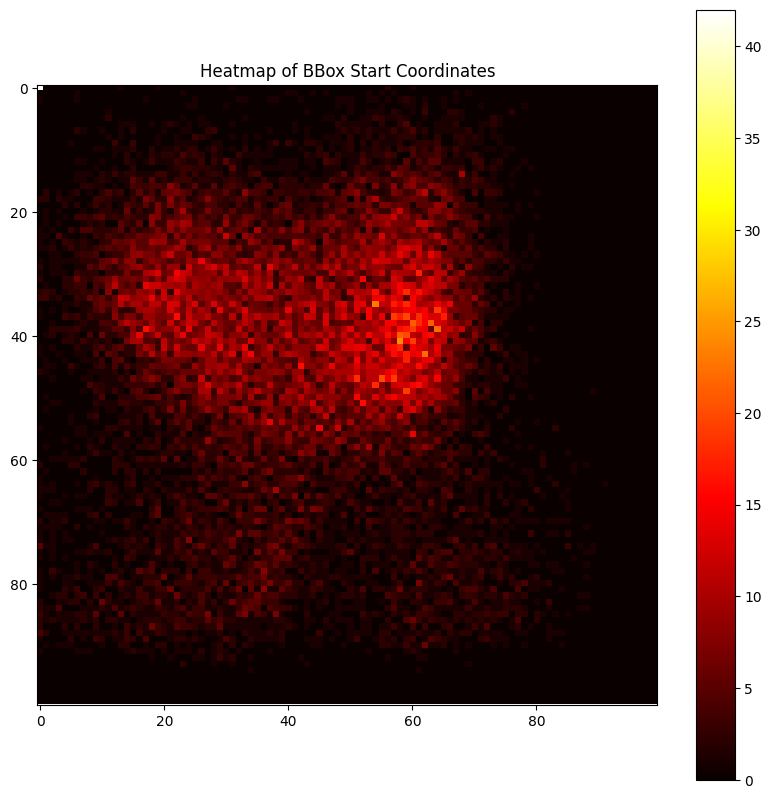

In [ ]:
heatmap = np.zeros((100, 100))  # Assuming normalized coordinates

for entry in combined_json_data:
    bboxes = entry[1]['bboxes']
    for bbox in bboxes:
        x, y, _, _ = [int(coord * 99) for coord in bbox]  # Multiplying by 99 to fit our heatmap size
        heatmap[y, x] += 1

plt.figure(figsize=(10, 10))
plt.imshow(heatmap, cmap='hot')
plt.colorbar()
plt.title('Heatmap of BBox Start Coordinates')
plt.show()


Leading Hand in Picture

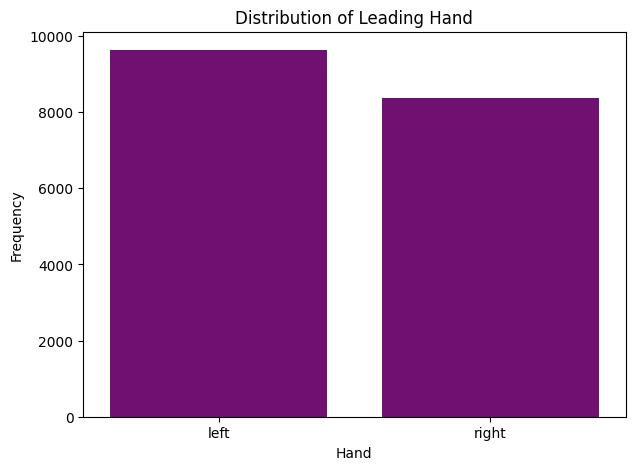

In [ ]:
# Extract leading hands
leading_hands = [entry[1]['leading_hand'] for entry in combined_json_data]

# Create the countplot
plt.figure(figsize=(7, 5))
sns.countplot(x=leading_hands, color="purple")
plt.title('Distribution of Leading Hand')
plt.xlabel('Hand')
plt.ylabel('Frequency')
plt.show()

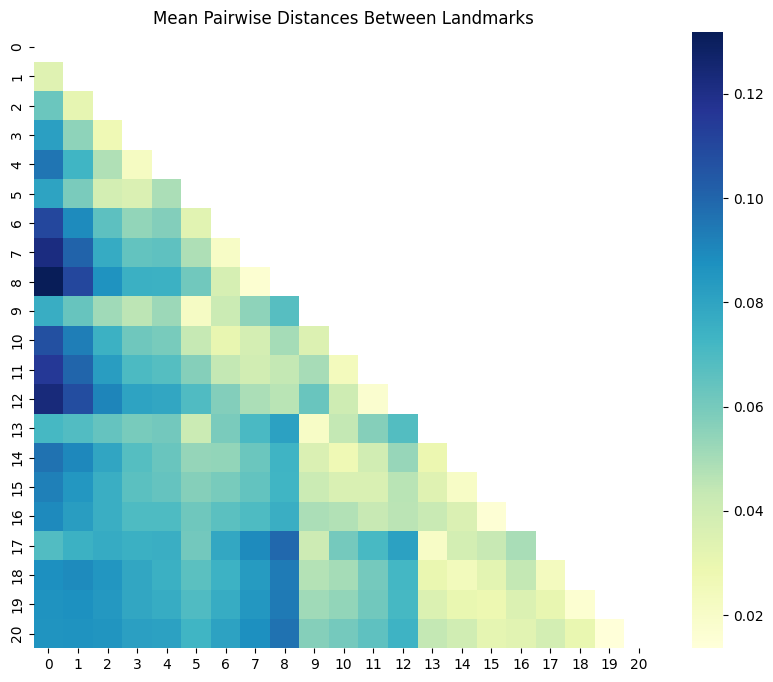

In [ ]:
def compute_pairwise_distances(landmarks):
    num_landmarks = len(landmarks)
    distances = np.zeros((num_landmarks, num_landmarks))

    for i in range(num_landmarks):
        for j in range(num_landmarks):
            # Convert landmarks to numpy arrays
            lm1 = np.array(landmarks[i])
            lm2 = np.array(landmarks[j])

            # Euclidean distance
            if lm1.shape == lm2.shape:  # Check if both landmarks have the same shape
                dist = np.linalg.norm(lm1 - lm2)
                distances[i, j] = dist

    return distances

# Compute mean distances
total_distances = np.mean([compute_pairwise_distances(lm) for lm in all_landmarks], axis=0)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(total_distances, dtype=bool))

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(total_distances, cmap="YlGnBu", mask=mask)
plt.title('Mean Pairwise Distances Between Landmarks')
plt.show()


Lighter blocks are where landmarks are close to each other, with the center being the distance to itself. Respectively, darker spots indicate larger distances between landmarks. This makes sense, since we see some darker spots towards the edges and lighter clusters towards the middle. This confirms that our data is looking as expected.

In [ ]:
# Extract bounding box sizes
bbox_areas = [w*h for entry in combined_json_data for _, _, w, h in entry[1]['bboxes']]

mean_area = np.mean(bbox_areas)
std_area = np.std(bbox_areas)
threshold_upper = mean_area + 3 * std_area
threshold_lower = mean_area - 3 * std_area

# Images with outlier bounding boxes
outliers_large = [entry for entry in combined_json_data if any(w*h > threshold_upper for _, _, w, h in entry[1]['bboxes'])]
outliers_small = [entry for entry in combined_json_data if any(w*h < threshold_lower for _, _, w, h in entry[1]['bboxes'])]

print(f"Mean bounding box area: {mean_area:.2f}")
print(f"Standard deviation of bounding box area: {std_area:.2f}")
print(f"Upper threshold: {threshold_upper:.2f}")
print(f"Lower threshold: {threshold_lower:.2f}")
print(f"Number of images with bounding boxes larger than the threshold: {len(outliers_large)}")
print(f"Number of images with bounding boxes smaller than the threshold: {len(outliers_small)}")

Mean bounding box area: 0.02
Standard deviation of bounding box area: 0.02
Upper threshold: 0.09
Lower threshold: -0.05
Number of images with bounding boxes larger than the threshold: 391
Number of images with bounding boxes smaller than the threshold: 0


In [ ]:
num_multi_bbox_images = len(multi_bbox_images)
num_no_bbox_images = len(no_bbox_images)

print(f"Number of images with multiple bounding boxes: {num_multi_bbox_images}")
print(f"Number of images with no bounding boxes: {num_no_bbox_images}")


Number of images with multiple bounding boxes: 4374
Number of images with no bounding boxes: 0
